In [1]:
import numpy as np
import pandas as pd
import os
from keras import backend as K
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.regularizers import l2
from keras import backend as K
import random
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pickle

/Users/harryxue/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
N_FRAMES = 128
INPUT_DIM = (128, 128, 1)
TRAINED_MODEL_PATH = 'trained_models/Siamese_FirstTrack_128x128/Siamese_FirstTrack_128x128.model'
HISTORY_PATH = 'trained_models/Siamese_FirstTrack_128x128/history.pickle'
FEATURE_DIR = '../data/features/mel_spec_first/'

In [3]:
# Load trained model
model = load_model(TRAINED_MODEL_PATH)
# Load training history
history = pickle.load(open(HISTORY_PATH, 'r'))

/Users/harryxue/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:1269: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


# Plot training history

In [ ]:
pd.Series(history['val_acc']).plot()
pd.Series(history['acc']).plot()

In [ ]:
pd.Series(history['val_loss']).plot()
pd.Series(history['loss']).plot()

In [4]:
influences = pd.read_csv('../data/allmusic/influences_cleaned.csv')
artists = pd.read_csv('../data/allmusic/artists_cleaned.csv')

# Create lookup dictionary mapping file id to artist id
file2id = {}

for filename in os.listdir(FEATURE_DIR):
    file2id[filename] = int(filename.split('.npy')[0]) 

id2file = {id:filename for (filename, id) in file2id.items()}

In [5]:
# Load validation relationship pairs
pos_val_rel, neg_val_rel = np.load('relationships/pos_val_rel.npy'), np.load('relationships/neg_val_rel.npy')

In [6]:
def sample_frames(melspec, n_frames):
    """Sample n_frames (contiguous) from a melspec representation"""
    total_frames = melspec.shape[1]
    sample_range = range(0, total_frames - n_frames + 1)
    sample_index = random.choice(sample_range)
    
    return melspec[:, sample_index:sample_index + n_frames]

In [7]:
def predict_val(pos_ex, neg_ex, model=model, n_frames=N_FRAMES):
    # Create binary labels for examples
    labels = np.concatenate((np.ones(len(pos_ex)), np.zeros(len(neg_ex))))
    all_ex = list(zip(np.concatenate((pos_ex, neg_ex)), labels))
    examples, labels = zip(*all_ex)
    
    Y_pred, Y_actual = [], []
    
    random.shuffle(all_ex)
    examples, labels = zip(*all_ex)

    for example, label in tqdm_notebook(zip(examples, labels)):
        # Extract sample of size N_FRAMES from mel_spec representation
        # for each example in pair
        pair_first, pair_second = [sample_frames(np.load(FEATURE_DIR + id2file[id]), n_frames) for id in example]
        pred = model.predict([pair_first[np.newaxis, :, :,np.newaxis], pair_second[np.newaxis, :, :, np.newaxis]])
        Y_pred.append(pred[0][0])
        Y_actual.append(label)
        
    return Y_pred, Y_actual, examples

In [8]:
Y_pred, Y_actual, id_pairs = predict_val(pos_val_rel, neg_val_rel)

A Jupyter Widget

In [12]:
# Save val predictions since prediction takes long time
pickle.dump(Y_pred, open('val_pred/Y_pred.npy', 'wb'))
pickle.dump(Y_actual, open('val_pred/Y_actual.npy', 'wb'))
pickle.dump(id_pairs, open('val_pred/id_pairs.npy', 'wb'))

# Precision, Recall, F-Score

In [13]:
accuracy_score(Y_actual, np.array(Y_pred) > 0.5)

0.7049833438372197

In [14]:
precision_score(Y_actual, np.array(Y_pred) > 0.5)

0.6925125776857058

In [15]:
recall_score(Y_actual, np.array(Y_pred) > 0.5)

0.7373728279463402

In [16]:
f1_score(Y_actual, np.array(Y_pred) > 0.5)

0.7142389953561384

# Accuracy for Same Genre Pairs v. Different Genre Pairs

In [17]:
# Create df for tracking whether genres are the same or not
genre_same_df = pd.DataFrame({'Y_actual': Y_actual, 'Y_pred': (pd.Series(Y_pred) > 0.5).apply(float), 'id_pair': id_pairs})

In [18]:
# Add column for whether genre is the same
genre_same_df['same_genre'] = genre_same_df['id_pair'].map(lambda x: artists[artists['id'] == x[0]]['main_genre'].iloc[0] == artists[artists['id'] == x[1]]['main_genre'].iloc[0])

In [19]:
# Add shared genre label if genre is the same
genre_same_df['shared_genre'] = genre_same_df['id_pair'].map(lambda x: artists[artists['id'] == x[0]]['main_genre'].iloc[0] if artists[artists['id'] == x[0]]['main_genre'].iloc[0] == artists[artists['id'] == x[1]]['main_genre'].iloc[0] else None)

In [21]:
# Calculate accuracy, precision, recall, F1 score
# for same genre pairs v. different pairs
print genre_same_df.groupby('same_genre').apply(lambda x: accuracy_score(x['Y_actual'], x['Y_pred']))
print genre_same_df.groupby('same_genre').apply(lambda x: precision_score(x['Y_actual'], x['Y_pred']))
print genre_same_df.groupby('same_genre').apply(lambda x: recall_score(x['Y_actual'], x['Y_pred']))
print genre_same_df.groupby('same_genre').apply(lambda x: f1_score(x['Y_actual'], x['Y_pred']))

same_genre
False    0.697102
True     0.713427
dtype: float64
same_genre
False    0.419786
True     0.848382
dtype: float64
same_genre
False    0.647133
True     0.767645
dtype: float64
same_genre
False    0.509237
True     0.805997
dtype: float64


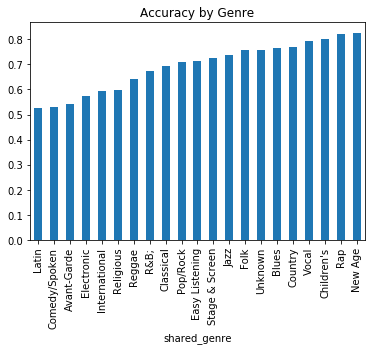

In [22]:
# Accuracy, precision, recall by genre for subset where genre is the same
genre_same_df[genre_same_df['same_genre'] == True].groupby('shared_genre')\
                                                .apply(lambda x: accuracy_score(x['Y_actual'], x['Y_pred']))\
                                                .sort_values()\
                                                .plot('bar', title='Accuracy by Genre')

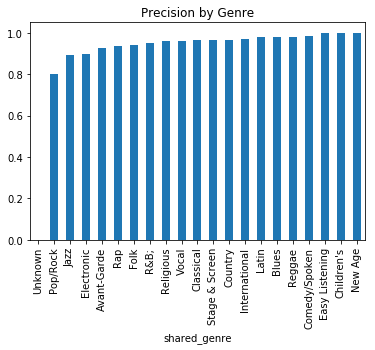

In [23]:
# Accuracy, precision, recall by genre for subset where genre is the same
genre_same_df[genre_same_df['same_genre'] == True].groupby('shared_genre')\
                                                .apply(lambda x: precision_score(x['Y_actual'], x['Y_pred']))\
                                                .sort_values()\
                                                .plot('bar', title='Precision by Genre')

### Accuracy, precision, recall by genre for subset where genre is the same

/Users/harryxue/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


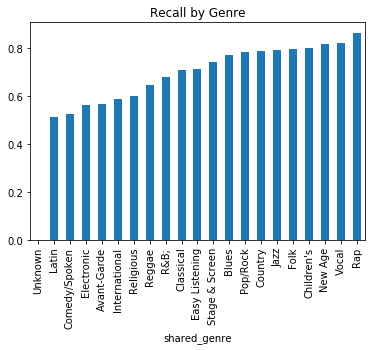

In [24]:
genre_same_df[genre_same_df['same_genre'] == True].groupby('shared_genre')\
                                                .apply(lambda x: recall_score(x['Y_actual'], x['Y_pred']))\
                                                .sort_values()\
                                                .plot('bar', title='Recall by Genre')

# Baseline: Accuracy for Samples From Same Song

In [ ]:
# Create "pairs" of the same id repeated to use as baseline
unique_val_ids = np.unique(np.append(neg_val_rel.flatten(), pos_val_rel.flatten()))
same_id_pairs = np.array([[id, id] for id in unique_val_ids])

In [ ]:
def predict_val_same_song(same_id_pairs, model=model, n_frames=N_FRAMES):
    # Create binary labels for examples
    labels = np.ones(len(same_id_pairs))
    all_ex = list(zip(same_id_pairs, labels))
    examples, labels = zip(*all_ex)
    
    Y_pred, Y_actual = [], []
    
    random.shuffle(all_ex)
    examples, labels = zip(*all_ex)

    for example, label in tqdm_notebook(zip(examples, labels)):
        # Extract sample of size N_FRAMES from mel_spec representation
        # for each example in pair
        pair_first, pair_second = [sample_frames(np.load(FEATURE_DIR + id2file[id]), n_frames) for id in example]
        pred = model.predict([pair_first[np.newaxis, :, :,np.newaxis], pair_second[np.newaxis, :, :, np.newaxis]])
        Y_pred.append(pred[0][0])
        Y_actual.append(label)
        
    return Y_pred, Y_actual, examples

In [ ]:
Y_pred_same, Y_actual_same, id_pairs_shuffled = predict_val_same_song(same_id_pairs)

In [ ]:
accuracy_score(Y_actual_same, np.array(Y_pred_same) > 0.5)

# Embed First Tracks for Each Artist and Visualize

In [ ]:
# Use weights from trained model to build a truncated embedding model to get
# fixed size embedding for each sample
input_shape = INPUT_DIM
left_input = Input(input_shape)
right_input = Input(input_shape)

embedding_model = Sequential()
embedding_model.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape, kernel_regularizer=l2(2e-4), weights=[model.layers[2].get_weights()[0], model.layers[2].get_weights()[1]]))
embedding_model.add(MaxPooling2D()) 
embedding_model.add(Conv2D(128,(7,7),activation='relu', kernel_regularizer=l2(2e-4), weights=[model.layers[2].get_weights()[2], model.layers[2].get_weights()[3]]))
embedding_model.add(MaxPooling2D())
embedding_model.add(Conv2D(128,(4,4),activation='relu',kernel_regularizer=l2(2e-4), weights=[model.layers[2].get_weights()[4], model.layers[2].get_weights()[5]]))
embedding_model.add(MaxPooling2D())
embedding_model.add(Conv2D(256,(4,4),activation='relu',kernel_regularizer=l2(2e-4), weights=[model.layers[2].get_weights()[6], model.layers[2].get_weights()[7]]))
embedding_model.add(Flatten())
embedding_model.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3), weights=[model.layers[2].get_weights()[8], model.layers[2].get_weights()[9]]))

In [ ]:
def siamese_embed(ids, embedding_model=embedding_model, n_frames=N_FRAMES):
    """Generate fixed size embeddings for samples using the trained Siamese network"""
    preds = []
    
    for id in tqdm_notebook(ids):
        # Extract sample of size N_FRAMES from mel_spec representation
        # for each example in pair
        sample = sample_frames(np.load(FEATURE_DIR + id2file[id]), n_frames) 
        pred = embedding_model.predict([sample[np.newaxis, :, :,np.newaxis]])[0]
        preds.append(pred)
    
    return preds

In [ ]:
ids = id2file.keys()
siamese_embeddings = siamese_embed(ids)

In [ ]:
# Create dict mapping id to embedding
embed_dict = dict(zip(ids, siamese_embeddings))

In [ ]:
# Top 7 most popular genres, removing 'Unknown'
top_genres = artists['main_genre'].value_counts()[:8].index.tolist()
top_genres.remove('Unknown')

In [ ]:
# Filter for ids of artists with > 25 followers
ids_filtered = artists[(artists['main_genre'].isin(top_genres))]['id'].tolist()

In [ ]:
# Create feature matrix
X = []
ids = []
# Create lists of artist name and main genre for visualization purposes
artist_names = []
main_genres = []

for id in ids_filtered:
    try:
        X.append(embed_dict[id].flatten())
        ids.append(id)
        main_genres.append(artists[artists['id'] == id]['main_genre'].iloc[0])
        artist_names.append(artists[artists['id'] == id]['name'].iloc[0])

    # we don't have audio for some ids, so pass
    except Exception as e:
        pass

X = np.array(X)

In [ ]:
# Scale to 0 mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
# Reduce dimensionality of X
X_reduced = pca.transform(X_scaled)

In [ ]:
# Percentage of variance explained
pca.explained_variance_ratio_

In [ ]:
pca_df = pd.DataFrame(dict(x=X_reduced[:,0], y=X_reduced[:,1], genre=main_genres, name=artist_names))
sns.lmplot('x', 'y', data=pca_df, hue='genre', fit_reg=False, scatter_kws={'alpha':0.5})
plt.title('First 2 Principle Components of Siamese Embeddings')